# Study $(e,e'\pi)$ missing mass and its relation to $z$

last edit Jan-13, 2021

## Imports and definitions

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sys; sys.path.insert(0, '/Users/erezcohen/Desktop/Software/mySoftware/Python/'); 
from my_tools               import *; 
from plot_tools             import *;
from my_data_analysis_tools import *;
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
r2d = 180./np.pi

In [2]:
main_data_path     = '/Users/erezcohen/Desktop/data/BAND/'
e_e_pi_data_path   = main_data_path + 'SIDIS_skimming/'
e_e_pi_n_data_path = main_data_path + 'merged_SIDIS_and_BAND_skimming/'

In [3]:
pi_charge_names  = ['piplus'   ,'piminus'  ]
pi_labels        = ['\pi^{+}'  ,'\pi^{-}'  ]
pi_colors        = ['royalblue','salmon'   ]

## Selection cuts not previously imposed

In [4]:
# for pi_charge_name in pi_charge_names:
#     # large momentum neutrons ( Pn > 275 MeV/c)
#     e_e_pi_n[pi_charge_name] = e_e_pi_n[pi_charge_name][e_e_pi_n[pi_charge_name]['n_P']>0.275]
    
#     print('retained',len(e_e_pi_n[pi_charge_name]),'(e,e',pi_charge_name,'n), events')        

## Auxiliary functions

In [5]:
fontsize = 18

In [6]:
def plot_step_hist( df, var='xB',
                   bins=np.linspace(0,1,10), label="$(e,e')$"):
    h,edges = np.histogram( df[var], bins=x_bins)
    h_err = np.sqrt(h)
    x     = (edges[1:] + edges[:-1])/2
    x_err = (edges[1:] - edges[:-1])/2
    plt.step ( x, h, color=pi_color, where='mid', label=label ) 
    plt.errorbar ( x, h, h_err, color=pi_color, marker='o', linestyle='None',label=None, capsize=2 )
    return x,h,x_err

In [7]:
def get_err_up_dw(x, xerr,lim_dw = 0,lim_up = 10):
    errup=xerr
    errdw=xerr
    
    for i in range(len(x)):
        if (x[i]+errup[i]) > lim_up:
            errup[i] = lim_up-x[i]
        
        if lim_dw > (x[i]-errdw[i]):
            errdw[i] = x[i]-lim_dw
        

    return errup,errdw

In [8]:
def compute_ratio_pips_to_pims(df_dict, var='xB', bins=np.linspace(0,1,10), z_min=0, z_max=1, 
                               theta_min=0, theta_max=np.pi, 
                               Mx_min=0, Mx_max=100,  
                               is_eepi=True):
    # z_min,z_max are z limits on the pion outgoing momentum
    df_pips = df_dict['piplus']
    df_pims = df_dict['piminus']
    # cut on z
    df_pips = df_pips[ (z_min<df_pips.Zpi) & (df_pips.Zpi<z_max) 
                      & (theta_min<df_pips.pi_Theta*r2d) & (df_pips.pi_Theta*r2d<theta_max) ]
    
    df_pims = df_pims[ (z_min     < df_pims.Zpi)          & (df_pims.Zpi          < z_max) 
                      & (theta_min< df_pims.pi_Theta*r2d) & (df_pims.pi_Theta*r2d < theta_max)]

    # and cut on Mx if its (e,e'pi)
    if is_eepi:#{
        df_pips = df_pips[ (Mx_min < df_pips.M_X) & (df_pips.M_X < Mx_max)]    
        df_pims = df_pims[ (Mx_min < df_pims.M_X) & (df_pims.M_X < Mx_max)]
    #}
    
    pips = df_pips[var]
    pims = df_pims[var]
    R_pips_to_pims, R_pips_to_pims_err = [],[]
    for x_min,x_max in zip(bins[:-1],bins[1:]):
        
        pips_in_bin  = pips[ (x_min < pips) & (pips < x_max) ]
        Npips_in_bin = len(pips_in_bin)
        pims_in_bin  = pims[ (x_min < pims) & (pims < x_max) ]
        Npims_in_bin = len(pims_in_bin)    

        R            = Npips_in_bin/np.max([Npims_in_bin,1])
        R_err        = R * np.sqrt( 1./np.max([1,Npips_in_bin]) + 1./np.max([1,Npims_in_bin]) )

        R_pips_to_pims    .append(R)
        R_pips_to_pims_err.append(R_err)
        
    R_pips_to_pims_errup,R_pips_to_pims_errdw = get_err_up_dw(R_pips_to_pims, R_pips_to_pims_err)
    
    return np.array(R_pips_to_pims),np.array(R_pips_to_pims_errup),np.array(R_pips_to_pims_errdw)

In [9]:
def compute_ratio_assymetry(df_dict, var='xB', bins=np.linspace(0,1,10), z_min=0, z_max=1,                                
                            theta_min=0, theta_max=np.pi,                             
                            Mx_min=0, Mx_max=100,
                            is_eepi=True):
    # z_min,z_max are z limits on the pion outgoing momentum
    df_pips = df_dict['piplus']
    df_pims = df_dict['piminus']
    # cut on z
    df_pips = df_pips[ (z_min<df_pips.Zpi) & (df_pips.Zpi<z_max) 
                      & (theta_min<df_pips.pi_Theta*r2d) & (df_pips.pi_Theta*r2d<theta_max) ]
    
    df_pims = df_pims[ (z_min     < df_pims.Zpi)          & (df_pims.Zpi          < z_max) 
                      & (theta_min< df_pims.pi_Theta*r2d) & (df_pims.pi_Theta*r2d < theta_max)]

    # and cut on Mx if its (e,e'pi)
    if is_eepi:#{
        df_pips = df_pips[ (Mx_min < df_pips.M_X) & (df_pips.M_X < Mx_max)]    
        df_pims = df_pims[ (Mx_min < df_pims.M_X) & (df_pims.M_X < Mx_max)]
    #}
    

    pips = df_pips[var]
    pims = df_pims[var]
    Rassymetry, Rassymetry_err = [],[]
    for x_min,x_max in zip(bins[:-1],bins[1:]):
        
        pips_in_bin  = pips[ (x_min < pips) & (pips < x_max) ]
        Npips_in_bin = len(pips_in_bin)
        pims_in_bin  = pims[ (x_min < pims) & (pims < x_max) ]
        Npims_in_bin = len(pims_in_bin)    

        nom          = (Npips_in_bin + Npims_in_bin)
        den          = np.max([Npips_in_bin - Npims_in_bin,1])
        R            = nom/den
        R_err        = np.abs(1/den) * np.sqrt(  Npips_in_bin*np.square(1 - Npips_in_bin/den)
                                               + Npims_in_bin*np.square(1 + Npims_in_bin/den) )

        Rassymetry    .append(R)
        Rassymetry_err.append(R_err)
        
    Rassymetry_errup,Rassymetry_errdw = get_err_up_dw(Rassymetry, Rassymetry_err)
    
    return np.array(Rassymetry),np.array(Rassymetry_errup),np.array(Rassymetry_errdw)

# Accumulated data from 101 runs of 10.2 GeV

## load data

In [10]:
runs_filename = "/Users/erezcohen/Desktop/Software/CLAS12/BAND/SIDIS_at_BAND/macros/runlists/good_runs_10-2-final.txt"

# Using readlines()
runs_file     = open(runs_filename, 'r')
run_fileLines = runs_file.readlines()
runs = []
for line in run_fileLines:#{
    run = int(line.strip())
    runs.append(run)
runs = np.array(runs)
runs

array([6420, 6421, 6422, 6426, 6428, 6429, 6430, 6431, 6432, 6433, 6437,
       6442, 6443, 6444, 6445, 6449, 6450, 6451, 6452, 6453, 6454, 6455,
       6456, 6457, 6458, 6461, 6462, 6463, 6464, 6465, 6466, 6467, 6468,
       6470, 6472, 6473, 6474, 6475, 6476, 6479, 6481, 6482, 6483, 6484,
       6485, 6486, 6488, 6489, 6491, 6492, 6498, 6499, 6501, 6502, 6510,
       6511, 6512, 6513, 6514, 6516, 6522, 6523, 6524, 6525, 6546, 6547,
       6548, 6549, 6550, 6557, 6558, 6559, 6560, 6562, 6563, 6565, 6566,
       6567, 6568, 6569, 6570, 6571, 6572, 6573, 6576, 6577, 6578, 6581,
       6582, 6585, 6586, 6587, 6589, 6590, 6591, 6592, 6593, 6595, 6596,
       6597, 6598])

In [11]:
fdebug   = 1
e_e_pi   = dict()
e_e_pi_n = dict()
for runnum,runIdx in zip(runs,range(len(runs))):
    for pi_charge_name in pi_charge_names:
        eepi   = pd.read_csv(e_e_pi_data_path 
                                           +'skimmed_SIDIS_inc_00%d_e_%s_selected_eepi_kinematics.csv'%(runnum,pi_charge_name))
        eepin = pd.read_csv(e_e_pi_n_data_path 
                                           +'skimmed_SIDIS_and_BAND_inc_00%d_e_%s_n.csv'%(runnum,pi_charge_name))        

        if fdebug>1: print('loaded',len(eepi),'(e,e',pi_charge_name,                  
                           ') events and ',
                           len(eepin),'(e,e',pi_charge_name,'n), events')    
    
        # large momentum neutrons ( Pn > 275 MeV/c)
        eepin = eepin[eepin['n_P']>0.275]
        if fdebug>2: print('retained',len(eepin),'(e,e',pi_charge_name,'n), events')            
        
        if runIdx==0:             
            e_e_pi[pi_charge_name]   = eepi
            e_e_pi_n[pi_charge_name] = eepin
        else:
            e_e_pi[pi_charge_name]   = pd.concat([e_e_pi[pi_charge_name],  eepi ])
            e_e_pi_n[pi_charge_name] = pd.concat([e_e_pi_n[pi_charge_name],eepin])
    print('loaded file %d/%d files'%(runIdx,len(runs)))

loaded file 0/101 files
loaded file 1/101 files
loaded file 2/101 files
loaded file 3/101 files
loaded file 4/101 files
loaded file 5/101 files
loaded file 6/101 files
loaded file 7/101 files
loaded file 8/101 files
loaded file 9/101 files
loaded file 10/101 files
loaded file 11/101 files
loaded file 12/101 files
loaded file 13/101 files
loaded file 14/101 files
loaded file 15/101 files
loaded file 16/101 files
loaded file 17/101 files
loaded file 18/101 files
loaded file 19/101 files
loaded file 20/101 files
loaded file 21/101 files
loaded file 22/101 files
loaded file 23/101 files
loaded file 24/101 files
loaded file 25/101 files
loaded file 26/101 files
loaded file 27/101 files
loaded file 28/101 files
loaded file 29/101 files
loaded file 30/101 files
loaded file 31/101 files
loaded file 32/101 files
loaded file 33/101 files
loaded file 34/101 files
loaded file 35/101 files
loaded file 36/101 files
loaded file 37/101 files
loaded file 38/101 files
loaded file 39/101 files
loaded fil

# Is there a background contamination at high-$z$ ?
We can check with in inclusive data

In [30]:
z_bins = [0.4,0.5,0.6,0.7,0.8,0.9]
z_widths = 0.05*np.ones(len(z_bins))

Nmax = 100000
var = 'M_X'
Mx_bins = np.linspace(1,5,30)

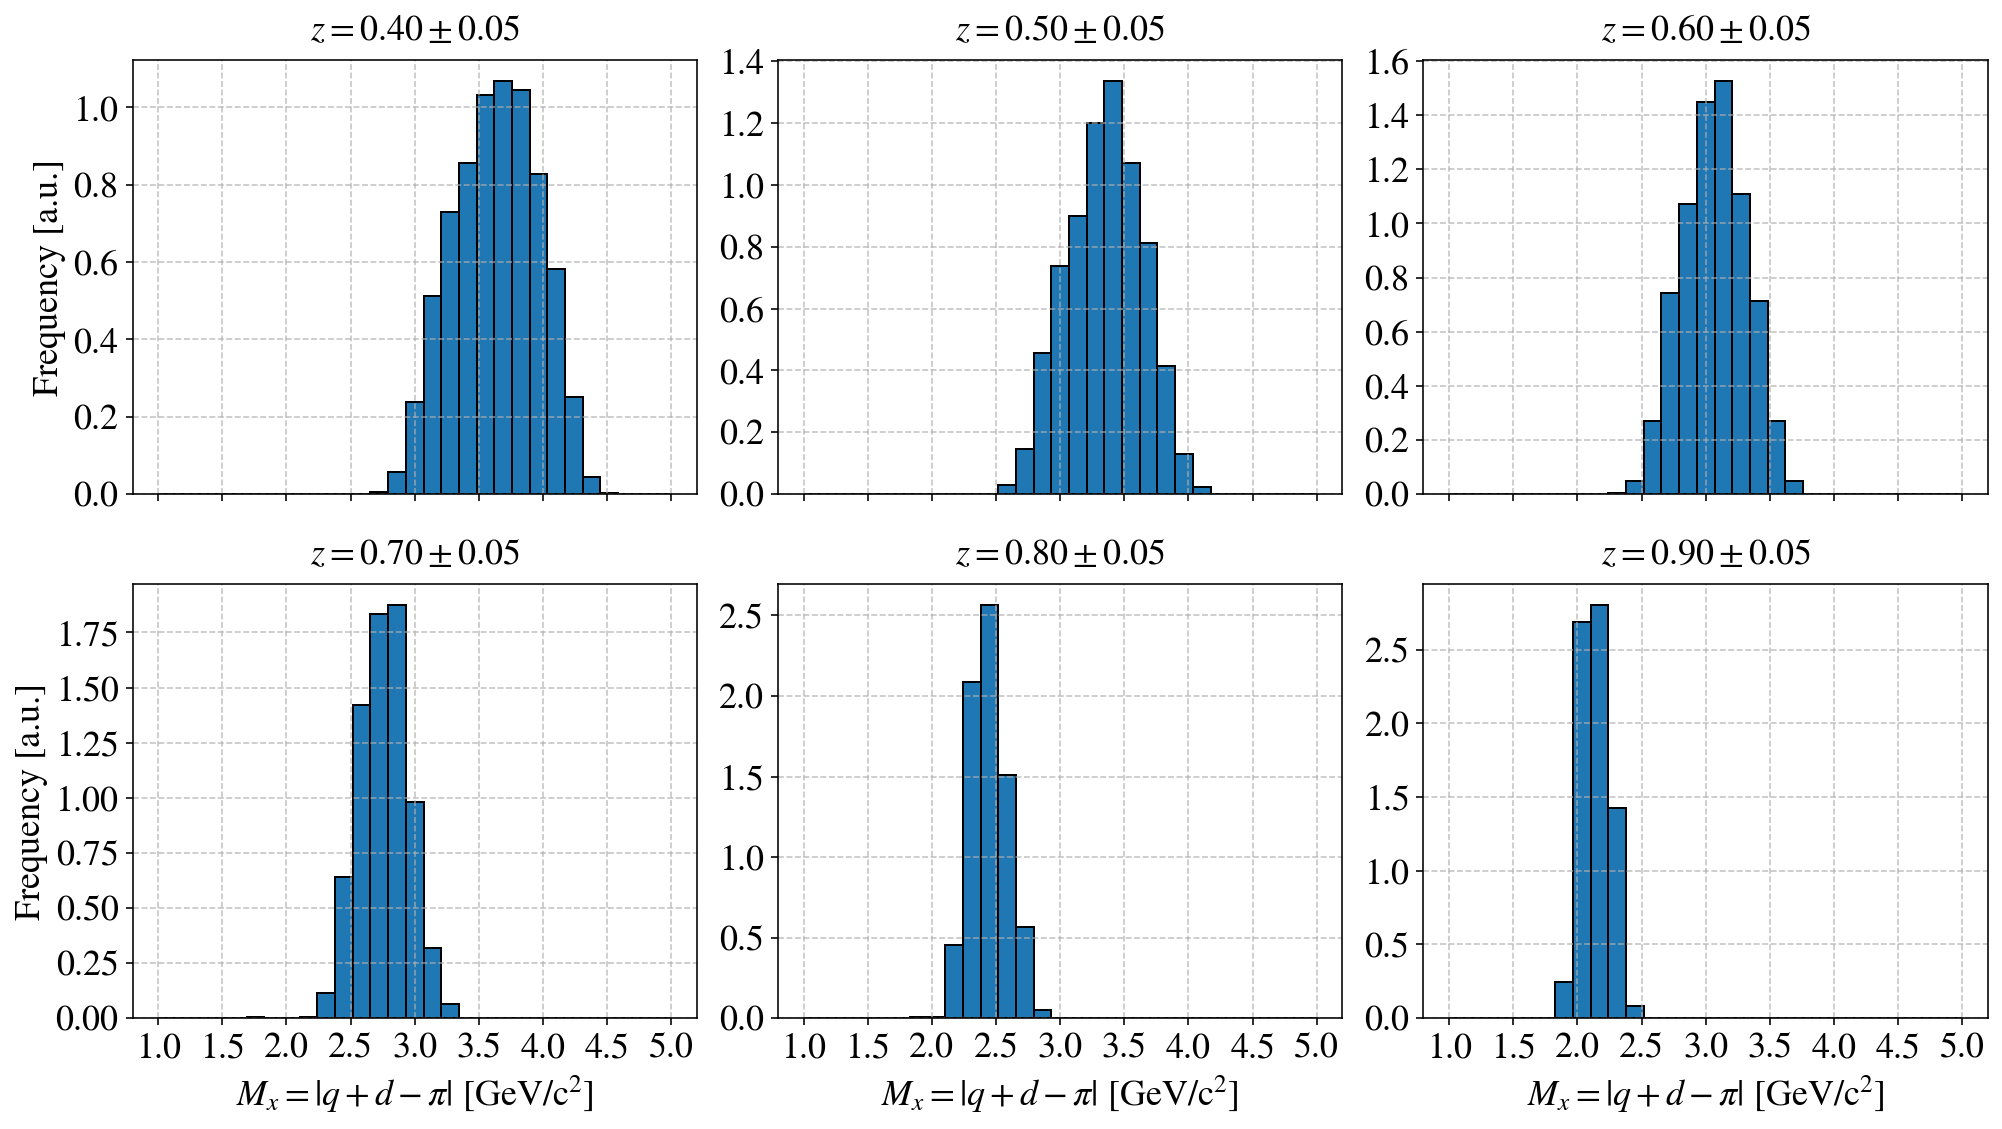

In [31]:

fig = plt.figure(figsize=(14,8))

for z_bin,z_width,z_idx in zip(z_bins,z_widths,range(len(z_bins))):#{
    z_min,z_max = z_bin-z_width,z_bin+z_width

    df_pips = e_e_pi['piplus'][0:Nmax]
    df_pips = df_pips[ (z_min<df_pips.Zpi) & (df_pips.Zpi<z_max) & (theta_min<df_pips.pi_Theta*r2d) & (df_pips.pi_Theta*r2d<theta_max)]
    Mx_pips = df_pips[var]
    ax  = fig.add_subplot(2,3,z_idx+1)
    plt.hist( Mx_pips, bins=Mx_bins, edgecolor='k' , density=True)
    set_axes(ax,"$M_x = |q + d - \pi|$ [GeV/c$^2$]" if z_idx>2 else "",
             "Frequency [a.u.]" if z_idx%3==0 else "",
             remove_ticks_x=False if z_idx>2 else True,
             title="$z = %.2f \pm %.2f$" %(z_bin,z_width),
         do_add_grid=True, do_add_legend=False, fontsize=fontsize);
#}
plt.tight_layout()